In [9]:
import pybamm
import timeit
from matplotlib import style
import numpy as np
style.use("ggplot")
pybamm.set_logging_level("INFO")

In [109]:
start = timeit.default_timer()
model = pybamm.lithium_ion.DFN(
    {
        "particle phases":("2", "1"),
        "open-circuit potential": (("single", "current sigmoid"), "single"),
        "cell geometry":"pouch"
    }
)

param_IB = pybamm.ParameterValues("Chen2020_composite")

param_IB.update(
    # Cell Characterisitics
    {"Negative current collector thickness [m]": 8.00e-06,
     "Separator thickness [m]": 1.60e-05,
     "Positive electrode thickness [m]": 1.23e-04,
     "Positive current collector thickness [m]": 1.20e-05,
     "Electrode height [m]": 1.68e-01,
     "Electrode width [m]" : 1.18e-01,
     "Cell cooling surface area [m2]": 2.06e-02,
     "Cell volume [m3]":1.11e-04,
     "Nominal cell capacity [A.h]":0.652e01,
     "Current function [A]": 1.02e01,
     "Number of electrodes connected in parallel to make a cell": 2.30e01,
     "Lower voltage cut-off [V]": 2.50e00,
     "Upper voltage cut-off [V]": 4.20e00,
     "Open-circuit voltage at 0% SOC [V]": 2.8627e00,
     "Open-circuit voltage at 100% SOC [V]": 4.1247e00,
     #Anode Characteristics
     "Negative electrode porosity": 4.20e-01,
     "Primary: Negative electrode active material volume fraction": 7.25e-01,
     "Primary: Negative particle radius [m]": 2.5e-05,
     #"Primary: Negative electrode OCP [V]": <function graphite_ocp_Enertech_Ai2020 at 0x000002046DF22520>,
     "Secondary: Negative electrode active material volume fraction": 1.42e-01,
     "Secondary: Negative particle radius [m]": 1.5e-06,
     #SEI Characteristics
     "Primary: Maximum concentration in negative electrode [mol.m-3]": 28700,
     "Primary: Initial concentration in negative electrode [mol.m-3]": 23000,
     "Primary: Negative particle diffusivity [m2.s-1]": 5.5e-14,
     "Secondary: Negative particle diffusivity [m2.s-1]": 1.67e-14,
     "Secondary: Initial concentration in negative electrode [mol.m-3]": 277000,
     "Secondary: Maximum concentration in negative electrode [mol.m-3]": 278000,
     #Cathode Characteristics
     "Positive electrode porosity":2.4e-01,
     "Positive electrode active material volume fraction": 9.04e-01,
     "Positive particle radius [m]": 5.5e-06,
     #Separator Characteristics
     "Separator porosity": 4.50e-01,
     "Separator density [kg.m-3]":7.87e02
    }#, check_already_exists=False
)        

2024-10-31 09:03:24.442 - [INFO] base_model._build_model(777): Start building Doyle-Fuller-Newman model
2024-10-31 09:03:24.487 - [INFO] base_battery_model.build_model(1042): Finish building Doyle-Fuller-Newman model


In [110]:
experiment_1 = pybamm.Experiment(
    [
        (
            "Charge at 0.33 C until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Rest for 5 minutes",
            "Discharge at 1C for 0.5 hours",
            "Rest for 5 minutes",
            "Discharge at 3C for 10 seconds",
            "Rest for 5 minutes",
            "Discharge at 0.33 C until 2.5 V",
            "Rest for 15 minutes",
        )
    ]
    * 2)
#defining simulation time (not necessary as we have already defined the experiment)
#t_eval = np.linspace(0, 10000, 1000)
solutions = {}
sim=pybamm.Simulation(model, parameter_values=param_IB, experiment=experiment_1, 
                         solver=pybamm.CasadiSolver(dt_max=5))
Sol_IB = sim.solve(calc_esoh=False)
solutions["Sol_IB"] = Sol_IB

#Comparision with dafault parameter values
param_default = pybamm.ParameterValues("Chen2020_composite")
sim=pybamm.Simulation(model, parameter_values= param_default, experiment=experiment_1, 
                         solver=pybamm.CasadiSolver(dt_max=5))
Sol_def = sim.solve(calc_esoh=False)
solutions["Sol_def"] = Sol_def

2024-10-31 09:03:30.972 - [INFO] callbacks.on_experiment_start(162): Start running experiment
2024-10-31 09:03:30.975 - [INFO] parameter_values.process_model(440): Start setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.033 - [INFO] parameter_values.process_model(509): Finish setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.035 - [INFO] parameter_values.process_model(440): Start setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.072 - [INFO] parameter_values.process_model(509): Finish setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.072 - [INFO] parameter_values.process_model(440): Start setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.912 - [INFO] parameter_values.process_model(509): Finish setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.912 - [INFO] parameter_values.process_model(440): Start setting parameters for Doyle-Fuller-Newman model
2024-10-31 09:03:31.970 - [I

In [111]:
solutions

{'Sol_IB': <pybamm.solvers.solution.Solution at 0x178027458d0>,
 'Sol_def': <pybamm.solvers.solution.Solution at 0x17802780050>}

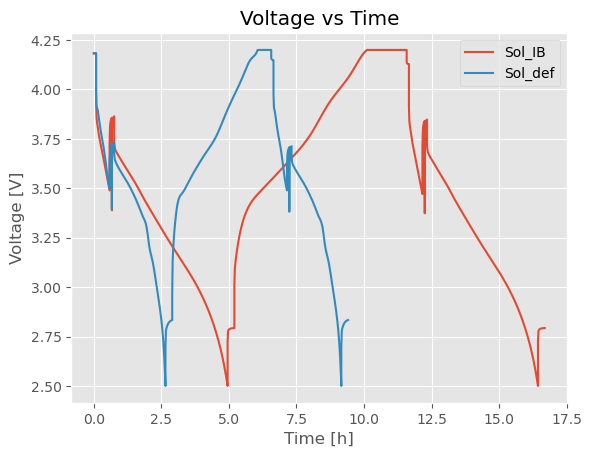

In [112]:
for name, sol in solutions.items():
    time = sol["Time [s]"].entries /3600
    voltage = sol["Voltage [V]"].entries
    plt.plot(time, voltage, label=name)
    plt.xlabel("Time [h]")
    plt.ylabel("Voltage [V]")
    plt.title("Voltage vs Time")
    plt.legend()
plt.show()

In [98]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

In [113]:
import plotly.graph_objects as go
import pandas as pd

# Initialize figure
fig = go.Figure()

# Loop through each solution and plot it
for name, sol in solutions.items():
    # Convert solution data into a DataFrame
    time = sol["Time [s]"].entries / 3600  # Convert to hours
    voltage = sol["Terminal voltage [V]"].entries
    df = pd.DataFrame({"Time [h]": time, "Voltage [V]": voltage})

    # Add trace to the figure
    fig.add_trace(go.Scatter(x=df["Time [h]"], y=df["Voltage [V]"], mode='lines', name=name))

# Customize the layout
fig.update_layout(
    title="Voltage vs Time for Different Simulations",
    xaxis_title="Time [h]",
    yaxis_title="Voltage [V]"
)

# Show the figure
fig.show()